# **Determining Biofilm Surface Area from 2D Images**

## **Image Loading and Gray-Scaling**


### **Importing Images from Utils**

In [45]:
from utils import *

print("All libraries successfully imported")

### **Image Grayscaling**

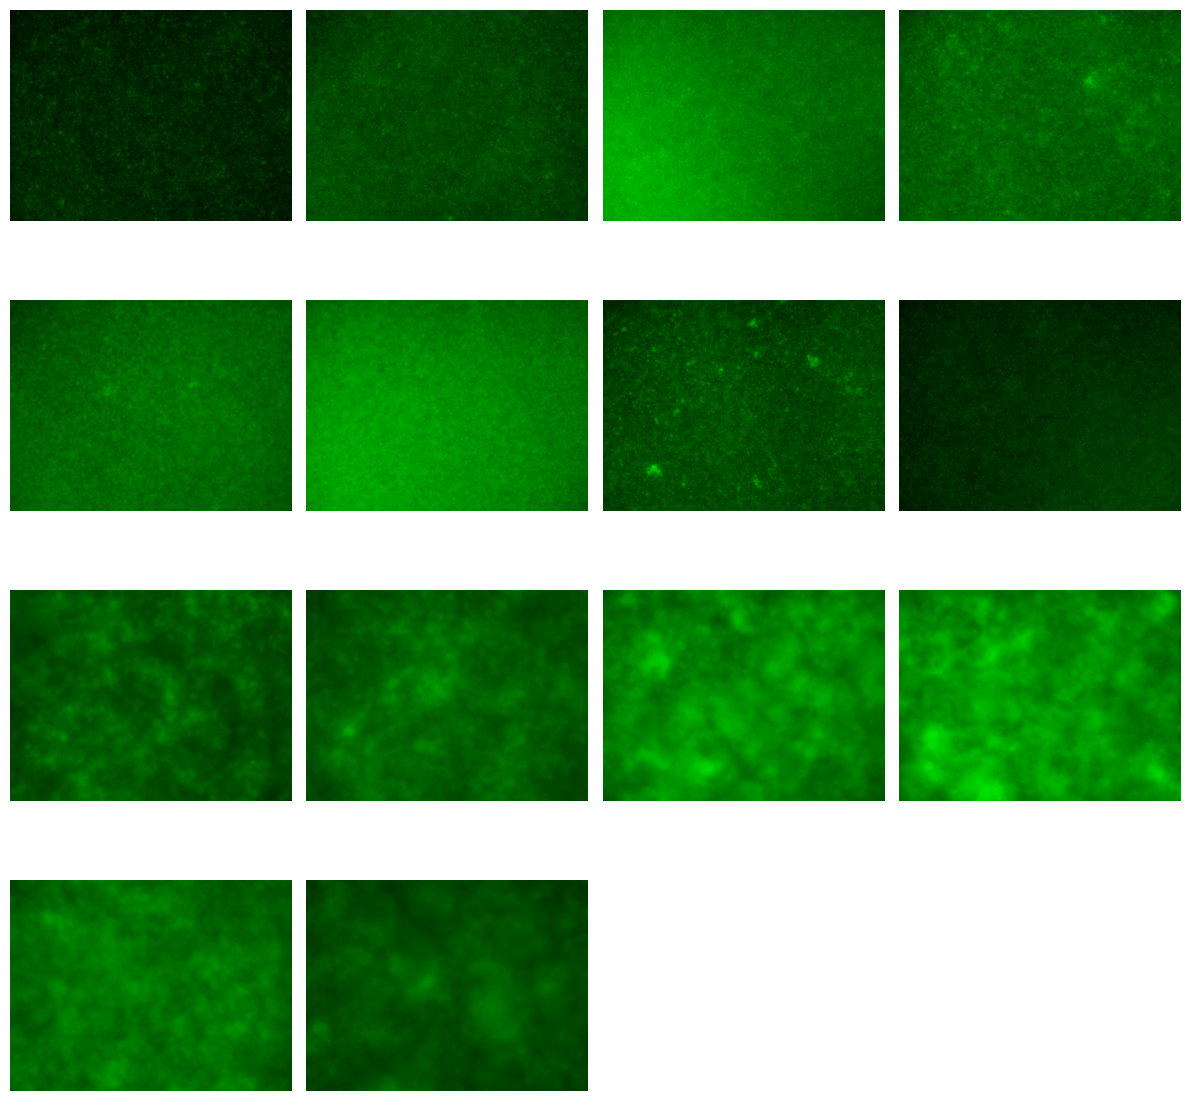

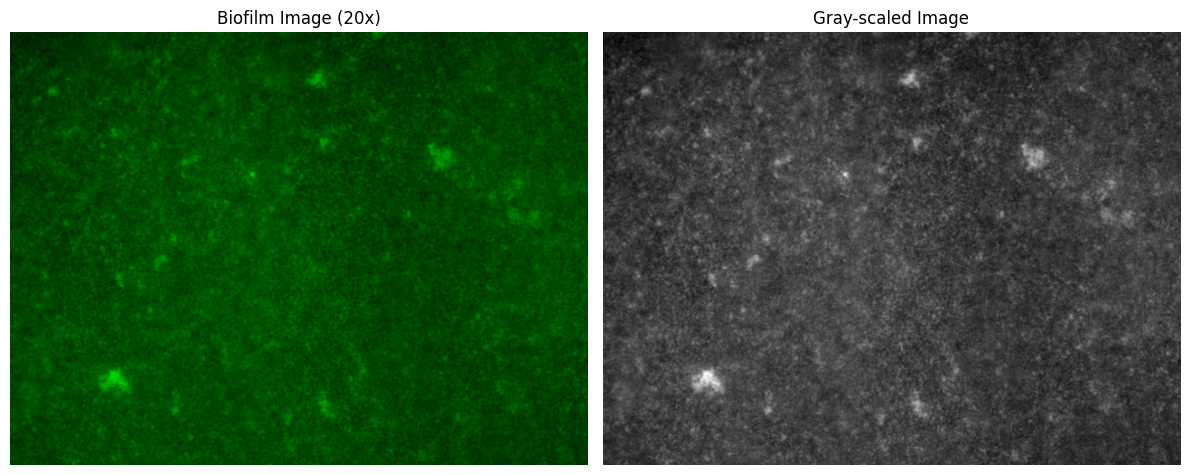

In [46]:
from utils import load_images, grayscale
biofilm_images = load_images("biofilm_data/biofilm")
display_grid_of_images(biofilm_images)
image = biofilm_images [6]
gray_image = grayscale(image)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title(f"Biofilm Image (20x)")
axes[0].axis('off')

axes[1].imshow(gray_image, cmap='gray')
axes[1].set_title("Gray-scaled Image")
axes[1].axis('off')
    
plt.tight_layout()
plt.show()

#print(image.shape)
#print(image)

## **Pre-processing of the Images**

### **CLAHE**
*CLAHE (Contrast Limited Adaptive Histogram Equalization) is an adaptive image technique that enhances local details throughout an image*

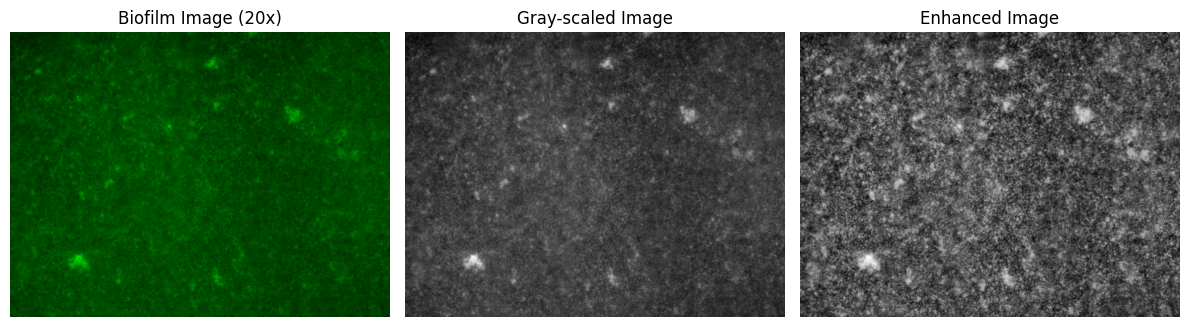

In [47]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_image = clahe.apply(gray_image)

fig, axes = plt.subplots(1, 3, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title(f"Biofilm Image (20x)")
axes[0].axis('off')

axes[1].imshow(gray_image, cmap='gray')
axes[1].set_title("Gray-scaled Image")
axes[1].axis('off')

axes[2].imshow(enhanced_image, cmap='gray')
axes[2].set_title("Enhanced Image")
axes[2].axis('off')
    
plt.tight_layout()
plt.show()

### **Normalization**
*Rescales all of the pixel intensities to remove any discrepancies that might come from different imaging conditions*

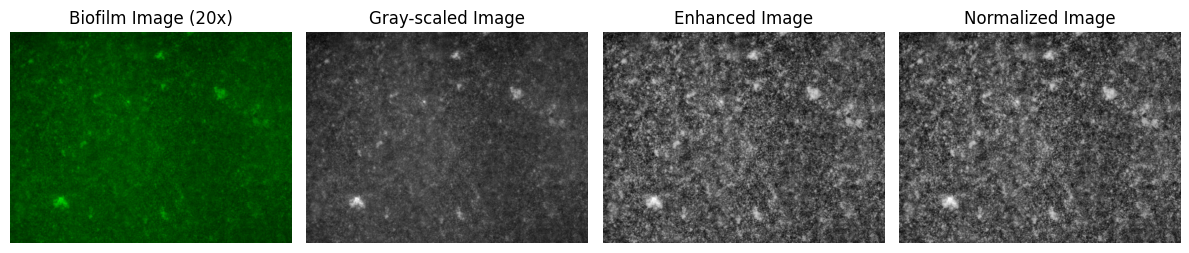

In [48]:
normalized_image = cv2.normalize(enhanced_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
normalized_image = clahe.apply(gray_image)

fig, axes = plt.subplots(1, 4, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title(f"Biofilm Image (20x)")
axes[0].axis('off')

axes[1].imshow(gray_image, cmap='gray')
axes[1].set_title("Gray-scaled Image")
axes[1].axis('off')

axes[2].imshow(enhanced_image, cmap='gray')
axes[2].set_title("Enhanced Image")
axes[2].axis('off')

axes[3].imshow(normalized_image, cmap='gray')
axes[3].set_title("Normalized Image")
axes[3].axis('off')
    
plt.tight_layout()
plt.show()

### **Gaussian Blur**
*Gaussian blur helps to smooth the edges of the pixels, cleaning up the data and making it easier for future analysis techniques*

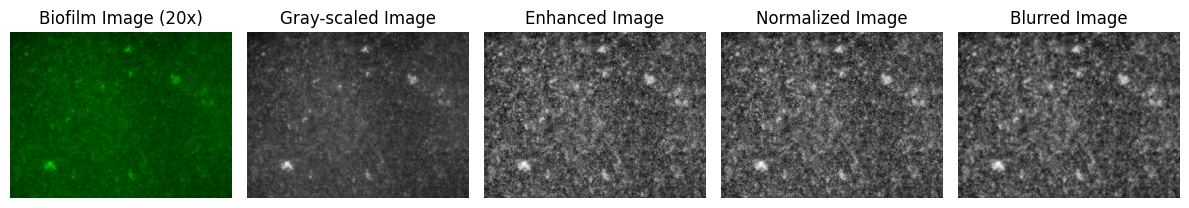

In [49]:
blurred_image = cv2.GaussianBlur(normalized_image, (5, 5), 0)

fig, axes = plt.subplots(1, 5, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title(f"Biofilm Image (20x)")
axes[0].axis('off')

axes[1].imshow(gray_image, cmap='gray')
axes[1].set_title("Gray-scaled Image")
axes[1].axis('off')

axes[2].imshow(enhanced_image, cmap='gray')
axes[2].set_title("Enhanced Image")
axes[2].axis('off')

axes[3].imshow(normalized_image, cmap='gray')
axes[3].set_title("Normalized Image")
axes[3].axis('off')

axes[4].imshow(blurred_image, cmap='gray')
axes[4].set_title("Blurred Image")
axes[4].axis('off')
    
plt.tight_layout()
plt.show()


## **Segmentation Techniques**

### **Otsu Segmentation**
*Automatically determines a thresholding value that is used to determine what is/isn't biofilm*

In [50]:
# --- Determine the Threshold Value ---

optimal_threshold, binary_mask = cv2.threshold(
    src=blurred_image, 
    thresh=0,           
    maxval=255,      
    type=cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

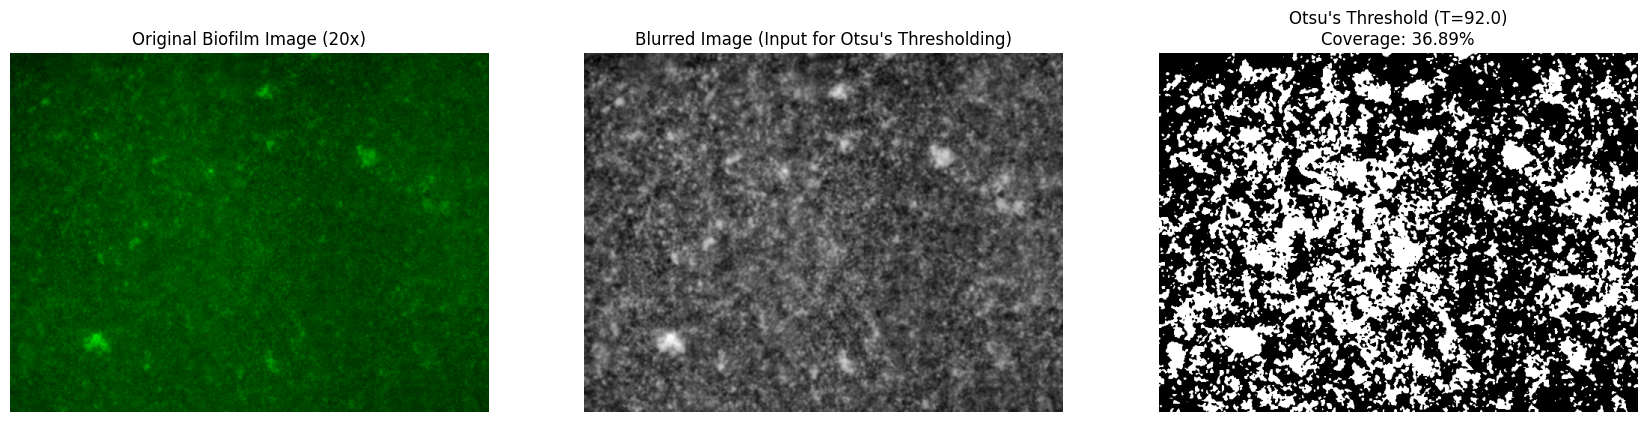

--- Segmentation Results (Otsu's) ---
Optimal Global Threshold: 92.0
Biofilm Surface Area Coverage: 36.89%


In [51]:
# --- Quantification and Visualization ---

# Count the biofilm pixels (white pixels)
biofilm_pixels = np.count_nonzero(binary_mask)
total_pixels = binary_mask.size
percent_coverage = (biofilm_pixels / total_pixels) * 100

# --- Display the results ---
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

axes[0].imshow(image)
axes[0].set_title("Original Biofilm Image (20x)")
axes[0].axis('off')

axes[1].imshow(blurred_image, cmap='gray')
axes[1].set_title("Blurred Image (Input for Otsu's Thresholding)")
axes[1].axis('off')

axes[2].imshow(binary_mask, cmap='gray')
axes[2].set_title(f"Otsu's Threshold (T={optimal_threshold})\nCoverage: {percent_coverage:.2f}%")
axes[2].axis('off')

plt.show()

print(f"--- Segmentation Results (Otsu's) ---")
print(f"Optimal Global Threshold: {optimal_threshold}")
print(f"Biofilm Surface Area Coverage: {percent_coverage:.2f}%")

### **Iterative Thresholding**
*Assumes that the image is composed of two main groups:*

 1. Foreground (biomass)
 2. Background (not biomass)

*The algorithm makes an initial guess, averages the gray-scaled pixel values above and below the threshold, creates a new threshold from the average of those two averages, and continues to iterate until the threshold value stops changing*

Optimal Iterative Threshold: 93
Converged in 10 iterations.


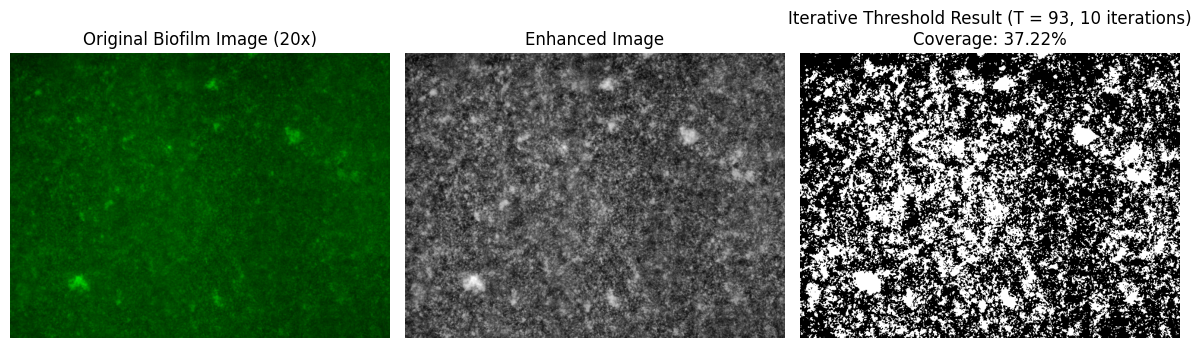

--- Segmentation Results (Iterative) ---
Optimal Global Threshold: 93
Biofilm Surface Area Coverage: 37.22%


In [54]:
def iterative_threshold(image):
    """
    Calculates the optimal threshold for a grayscale image using the 
    Iterative Selection method described by Yang et al. (2001).

    Based on: Yang et al. (2001) Wat. Res. Vol. 35, No. 5, pp. 1149-1158.
    [cite_start][cite: 5987-6002]
    """
    
    # Initialize iteration counter
    iteration_count = 0
    
    # Start with an initial guess for the threshold.
    # A common choice is the middle of the gray-scale range (0-255).
    current_threshold = 127.0
    
    # Store the last threshold to check for convergence
    last_threshold = -1.0
    
    # Set a convergence criteria. We stop when the threshold
    # changes by less than 0.5 gray levels.
    tolerance = 0.5
    
    # --- Start the Iterative Loop ---
    # The loop continues as long as the threshold is changing
    while abs(current_threshold - last_threshold) > tolerance:
        
        # Increment iteration count
        iteration_count += 1
        
        # Store the current threshold before recalculating
        last_threshold = current_threshold
        
        # 1. Segment the image into background and foreground based on the current threshold
        # Using numpy masking is highly efficient
        background_pixels = image[image <= current_threshold]
        foreground_pixels = image[image > current_threshold]
        
        # 2. Calculate the mean gray value of each group
        # Check for empty arrays to avoid errors (e.g., all-black/all-white images)
        if background_pixels.size == 0:
            mean_bg = 0.0
        else:
            mean_bg = np.mean(background_pixels)
            
        if foreground_pixels.size == 0:
            mean_fg = 255.0
        else:
            mean_fg = np.mean(foreground_pixels)
        
        # 3. Calculate the new threshold by averaging the two means
        current_threshold = (mean_bg + mean_fg) / 2.0
        
    # --- End of Loop ---
    
    # Return the final, stable threshold as an integer and the iteration count
    return int(round(current_threshold)), iteration_count

# --- Calculate the optimal threshold AND get the iteration count ---
optimal_t, iterations = iterative_threshold(blurred_image)

print(f"Optimal Iterative Threshold: {optimal_t}")
print(f"Converged in {iterations} iterations.")

# Apply the calculated threshold to the image to get a binary image
# [cite_start]This creates the binary image of biomass and interstitial space [cite: 5755-5757]
ret, binary_image = cv2.threshold(enhanced_image, optimal_t, 255, cv2.THRESH_BINARY)

# Count the biofilm pixels (white pixels)
biofilm_pixels = np.count_nonzero(binary_image)
total_pixels = binary_image.size
percent_coverage = (biofilm_pixels / total_pixels) * 100

# Display the results for comparison
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

axes[0].imshow(image)
axes[0].set_title("Original Biofilm Image (20x)")
axes[0].axis('off')

axes[1].imshow(enhanced_image, cmap='gray')
axes[1].set_title("Enhanced Image")
axes[1].axis('off')

axes[2].imshow(binary_image, cmap='gray')
axes[2].set_title(f"Iterative Threshold Result (T = {optimal_t}, {iterations} iterations)\nCoverage: {percent_coverage:.2f}%")
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"--- Segmentation Results (Iterative) ---")
print(f"Optimal Global Threshold: {optimal_t}")
print(f"Biofilm Surface Area Coverage: {percent_coverage:.2f}%")

## **Surface Area Calculation**
*Assuming each pixel is 1.13 microns by 1.13 microns (need to double check this is correct)*

In [53]:
def calculate_physical_area(binary_mask, pixel_side_length_um=1.13):
    """
    Calculate the physical area of biofilm from a binary mask.
    
    Parameters:
    -----------
    binary_mask : np.ndarray
        Binary image where non-zero pixels represent biofilm
    pixel_side_length_um : float
        Side length of a pixel in micrometers (default: 200)
    
    Returns:
    --------
    dict : Dictionary containing area calculations
    """
    # 1. Count the number of biofilm pixels (non-zero pixels)
    biofilm_pixels = np.count_nonzero(binary_mask)
    
    # 2. Calculate the area of a single pixel in square microns
    area_per_pixel_um2 = pixel_side_length_um ** 2
    
    # 3. Calculate the total area in square microns
    total_area_um2 = biofilm_pixels * area_per_pixel_um2
    
    # 4. Convert to square millimeters (1 mm^2 = 1,000,000 μm^2)
    total_area_mm2 = total_area_um2 / 1_000_000
    
    return {
        'biofilm_pixel_count': biofilm_pixels,
        'area_per_pixel_um2': area_per_pixel_um2,
        'total_area_um2': total_area_um2,
        'total_area_mm2': total_area_mm2
    }

# Calculate area using Otsu's thresholding result (binary_mask from Cell 12)
otsu_area_results = calculate_physical_area(binary_mask, pixel_side_length_um=1.13)

# Calculate area using iterative thresholding result (binary_image from Cell 15)
iterative_area_results = calculate_physical_area(binary_image, pixel_side_length_um=1.13)

# Display results
print("=" * 60)
print("--- Physical Area Results ---")
print("=" * 60)
print("Otsu Thresholding Surface Area Results:")
print(f"  Biofilm Pixel Count: {otsu_area_results['biofilm_pixel_count']:,}")
print(f"  Area per Pixel: {otsu_area_results['area_per_pixel_um2']:.2f} μm²")
print(f"  Total Area: {otsu_area_results['total_area_um2']:.2f} μm²")
print(f"  Total Area: {otsu_area_results['total_area_mm2']:.4f} mm²")

print("\nIterative Thresholding Surface Area Results:")
print(f"  Biofilm Pixel Count: {iterative_area_results['biofilm_pixel_count']:,}")
print(f"  Area per Pixel: {iterative_area_results['area_per_pixel_um2']:.2f} μm²")
print(f"  Total Area: {iterative_area_results['total_area_um2']:.2f} μm²")
print(f"  Total Area: {iterative_area_results['total_area_mm2']:.4f} mm²")
print("=" * 60)

--- Physical Area Results ---
Otsu Thresholding Surface Area Results:
  Biofilm Pixel Count: 113,338
  Area per Pixel: 1.28 μm²
  Total Area: 144721.29 μm²
  Total Area: 0.1447 mm²

Iterative Thresholding Surface Area Results:
  Biofilm Pixel Count: 114,336
  Area per Pixel: 1.28 μm²
  Total Area: 145995.64 μm²
  Total Area: 0.1460 mm²
